Compare to open clusters, none of them work so well... So gonna try using bins in multiple parameter space


From AS stars:

Best Rvar bin size: log(Rvar)=1.5; Temp=1000.0; pc=0.85      (max pc)
                    log(Rvar)=0.5; Temp= 400.0; slope=1.01   (max slope)

Best Prot bin size: log(Prot)=0.07; Temp=550.0; pc=0.96      (max pc)
                    log(Prot)=0.03; Temp=550.0; slope=1.08   (max slope)


In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [8]:
dfRvar=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')
dfProt=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')


# Open clusters

In [9]:
Clusters=pd.read_table('OpenClusters/JasonCluster2020April08.csv',delimiter=',')
#Clusters['AGE']=NGC6811['AGE']
Clusters.columns

Index(['CLUSTER', 'DR2NAME', 'DR2_NUM', 'ID', 'ID_SOURCE', 'RA', 'DEC',
       'BP_RP', 'GMAG', 'AGE', 'AV', 'PLX', 'DISTANCE', 'DM', 'BP_RP_0', 'M_G',
       'BINARY_SHORT', 'BINARY_WIDE', 'PROT', 'E_PROT', 'PROT_REF', 'TEFF',
       'MASS', 'BENCH'],
      dtype='object')

In [10]:
#from astropy.table import Table
#t = Table.from_pandas(Clusters)
#t.write('clusters.fits')

In [11]:
dfRvar_cluster=pd.merge(dfRvar[['teff_calc','Rvar','designation','age','KID']],Clusters,left_on='designation',right_on='DR2NAME',how='inner')
dfProt_cluster=pd.merge(dfProt[['teff_calc','Prot','designation','age','KID']],Clusters,left_on='designation',right_on='DR2NAME',how='inner')
print(len(dfRvar_cluster),len(dfProt_cluster))
clusternames=dfRvar_cluster.CLUSTER.unique()
clusternames

146 71


array(['NGC_6819', 'NGC_6811'], dtype=object)

# Calibrate bin size using open clusters

In [12]:
def Calcdv_bin(df,f1,f2,binsize_temp,binsize_rot,compclust):
    KIDs=compclust['KID']
    Nstars=len(KIDs)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    # initialize velocity dispersion
    compclust['ages']=np.zeros(Nstars)
    for i in range(Nstars):
        #update_progress(i/Nstars)
        teff = (df.loc[df['KID']==KIDs[i]])[f1].values[0]
        Prot = (df.loc[df['KID']==KIDs[i]])[f2].values[0]
        
        NNstars=df.loc[abs(df[f1]-teff)<=binsize_temp/2]
        NNstars=NNstars.loc[abs(df[f2]-Prot)<=binsize_rot/2]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        compclust['ages'].iloc[i]=v_to_age(1.5*MAD,p_mp)
    
    #plt.figure()
    #plt.plot(compclust['ages'], compclust['AGE'],'o')
    #print(compclust['ages'])
    z = np.polyfit(compclust['ages'], compclust['AGE'], 1)
    
    Clusternames=compclust['CLUSTER'].unique()
    stds=np.zeros(len(Clusternames))
    
    slope=z[0]
    
    for i in range(len(Clusternames)):
        single_clus=compclust.loc[compclust['CLUSTER']==Clusternames[i]]
        stds[i]=np.std(single_clus['ages'])
    avestd=np.mean(stds)
    
    return slope,avestd
        
        
        

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

p_mp, p_mr, p_a = get_avr_coefficients()

In [482]:
def findstars(df,f1_star,f2_star,f1='teff_calc',f2='Prot'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot=f1_star[i],f2_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


In [253]:
KIDs=findstars(dfProt,Clusters['TEFF'],Clusters['PROT'])

Progress: [####################] 99.9%


In [485]:
test='Prot'


bintemps=[300,400,450,500,550,600,650,700,800,900,1000]
if test=='Rvar':
    binprots=[0.4,0.5,0.7,0.8,1.,1.2,1.5,1.7]
    KID_recalc=dfRvar_cluster['KID'].unique()
    df=dfRvar
    f2='Rvar_log'
    df_cluster=dfRvar_cluster
else:
    binprots=[0.01+0.01*i for i in range(17)]
    KID_recalc=dfProt_cluster['KID'].unique()
    f2='Prot_log'
    df=dfProt
    df_cluster=dfProt_cluster
Ntry=int(len(bintemps)*len(binprots))

count=0

slopes=np.zeros(Ntry)
stds=np.zeros(Ntry)
tempbin_a=np.zeros(Ntry)
rotbin_a=np.zeros(Ntry)


for i in range(len(bintemps)):
    for j in range(len(binprots)):
        update_progress(count/(len(bintemps)*len(binprots)))
        tempbin=bintemps[i]
        protbin=binprots[j]
        
        tempbin_a[count]=tempbin
        rotbin_a[count]=protbin
        
        slopes[count],stds[count]=Calcdv_bin(df,'teff_calc',f2,tempbin,protbin,df_cluster)
        
        count=count+1
    


Progress: [####################] 99.5%


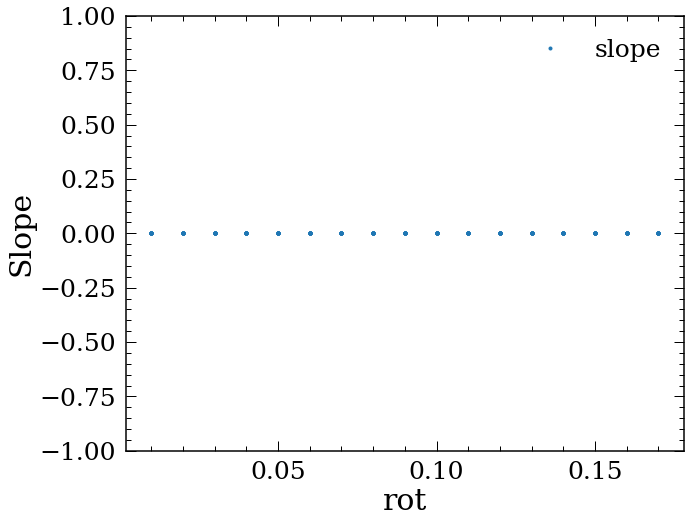

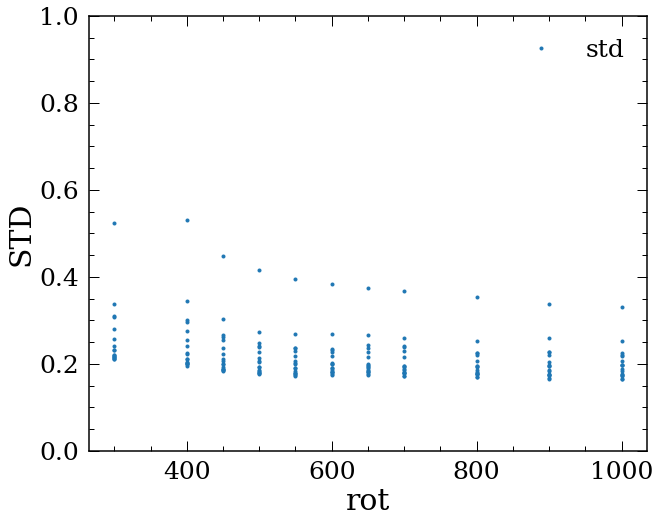

In [486]:
# Prot
plt.figure(figsize=(10,8))
plt.plot(rotbin_a,slopes,'.',label='slope')
plt.xlabel('rot')
plt.ylabel('Slope')
plt.ylim([-1,1])
plt.legend()


plt.figure(figsize=(10,8))
plt.plot(tempbin_a,stds,'.',label='std')
plt.ylabel('STD')
plt.xlabel('rot')
plt.ylim([0,1])
plt.legend()


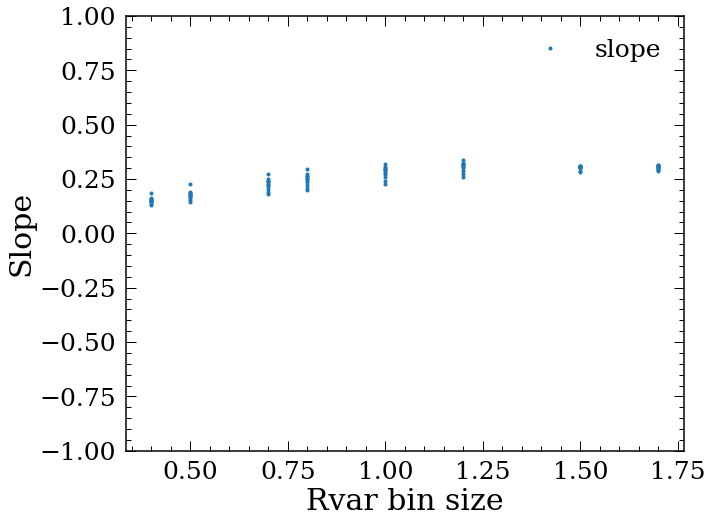

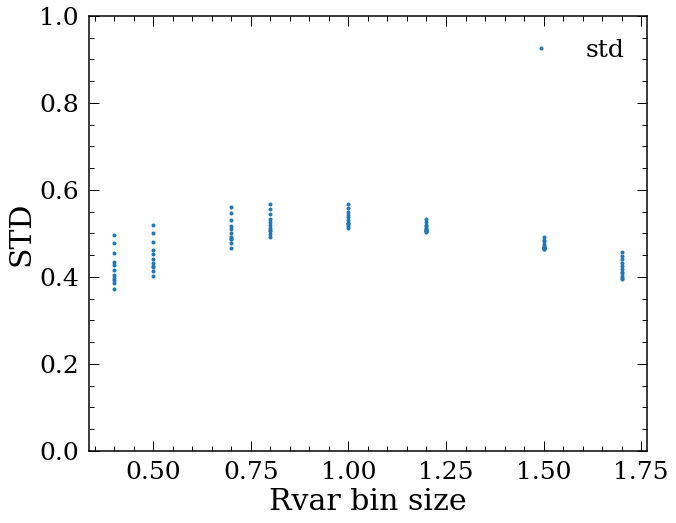

In [262]:
# Rvar
plt.figure(figsize=(10,8))
plt.plot(rotbin_a,slopes,'.',label='slope')
plt.xlabel('Rvar bin size')
plt.ylabel('Slope')
plt.ylim([-1,1])
plt.legend()


plt.figure(figsize=(10,8))
plt.plot(rotbin_a,stds,'.',label='std')
plt.ylabel('STD')
plt.xlabel('Rvar bin size')
plt.ylim([0,1])
plt.legend()



Text(0, 0.5, '$R_{var}$ [ppm]')

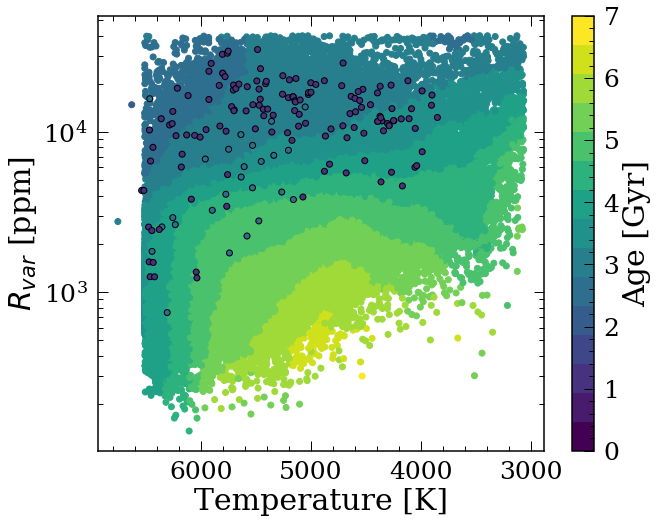

In [263]:
Clusters['KID']=KIDs
df_CLUSTERS_Rvar=pd.merge(Clusters,dfRvar[['KID','age','Rvar']],left_on='KID',right_on='KID',how='inner')

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(dfRvar['teff_calc'],dfRvar['Rvar'],c=dfRvar['age'],cmap=cm,vmin=0,vmax=7)
for name in clusternames:
    dfRvar_cluster_single=df_CLUSTERS_Rvar.loc[df_CLUSTERS_Rvar['CLUSTER']==name]
    plt.scatter(dfRvar_cluster_single['TEFF'],dfRvar_cluster_single['Rvar'],
                c=dfRvar_cluster_single['AGE'],cmap=cm,vmin=0,vmax=7,edgecolor='k')
cb=plt.colorbar()
#plt.ylim([0,50000])
cb.set_label('Age [Gyr]')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('$R_{var}$ [ppm]')



(0, 5)

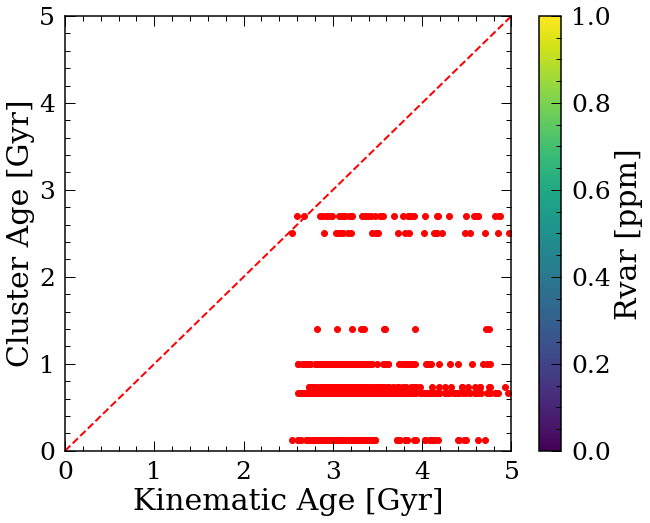

In [222]:
plt.figure(figsize=(10,8))
plt.scatter(df_CLUSTERS_Rvar['age'],df_CLUSTERS_Rvar['AGE'],c='r',cmap=cm)
plt.plot([0,5],[0,5],'r--')
cb=plt.colorbar()
#plt.ylim([0,50000])
cb.set_label('Rvar [ppm]')
plt.xlabel('Kinematic Age [Gyr]')
plt.ylabel('Cluster Age [Gyr]')
plt.xlim([0,5])
plt.ylim([0,5])

Pleiades 0.12
Praesepe 0.67
Hyades 0.73
NGC_6811 1.0
NGC_752 1.4
NGC_6819 2.5
Ruprecht_147 2.7


Text(0, 0.5, 'Prot [days]')

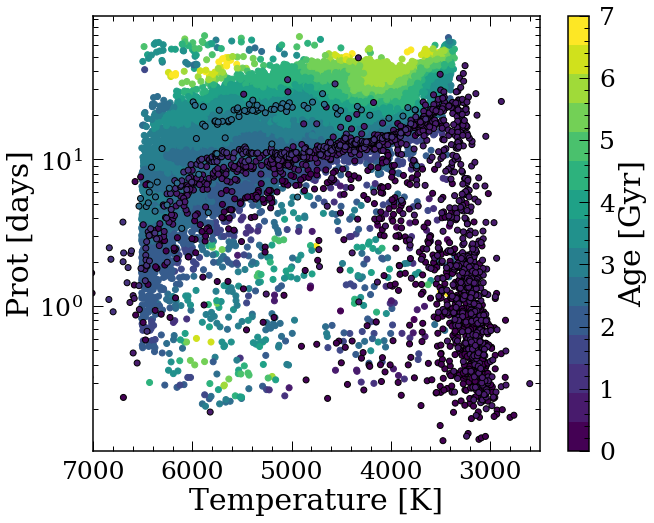

In [182]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(dfProt['teff_calc'],dfProt['Prot'],c=dfProt['age'],cmap=cm,vmin=0,vmax=7)
for name in Clusters.CLUSTER.unique():
    dfProt_cluster_single=Clusters.loc[Clusters['CLUSTER']==name]
    print(name,dfProt_cluster_single['AGE'].iloc[0])
    plt.scatter(dfProt_cluster_single['TEFF'],dfProt_cluster_single['PROT'],
                c=dfProt_cluster_single['AGE'],cmap=cm,vmin=0,vmax=7,edgecolor='k')
    
cb=plt.colorbar()
plt.xlim([2500,7000])
plt.yscale('log')
cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')



(0, 5)

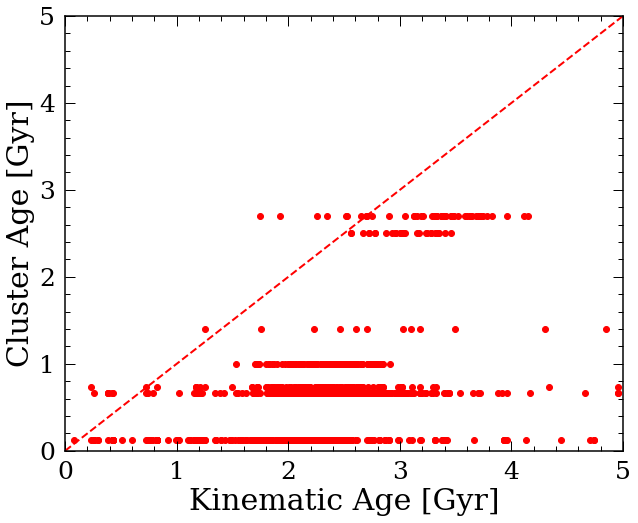

In [215]:
Clusters['KID']=KIDs
df_CLUSTERS=pd.merge(Clusters,dfProt[['KID','age']],left_on='KID',right_on='KID',how='inner')

plt.figure(figsize=(10,8))
plt.scatter(df_CLUSTERS['age'],df_CLUSTERS['AGE'],c='r',cmap=cm)
plt.plot([0,5],[0,5],'r--')

#plt.ylim([0,50000])
plt.xlabel('Kinematic Age [Gyr]')
plt.ylabel('Cluster Age [Gyr]')
plt.xlim([0,5])
plt.ylim([0,5])

In [228]:
Clusters.to_pickle('OpenClusters/clusters.pkl')

# Calibrate with astroseismic stars

In [13]:
import scipy
def Calcdv_bin(df,f1,f2,binsize_temp,binsize_rot,binsize_logg,ASstars,plot=False):
    KIDs=ASstars['KID']
    Nstars=len(KIDs)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    # initialize velocity dispersion
    ASstars['ages']=np.zeros(Nstars)
    for i in range(Nstars):
        #update_progress(i/Nstars)
        teff = (df.loc[df['KID']==KIDs[i]])[f1].values[0]
        Prot = (df.loc[df['KID']==KIDs[i]])[f2].values[0]
        try:
            logg = (df.loc[df['KID']==KIDs[i]])['logg'].values[0]
            loggo='logg'
        except:
            logg = (df.loc[df['KID']==KIDs[i]])['logg_y'].values[0]
            loggo='logg_y'
        
        NNstars=df.loc[abs(df[f1]-teff)<=binsize_temp/2]
        NNstars=NNstars.loc[abs(df[f2]-Prot)<=binsize_rot/2]
        NNstars=NNstars.loc[abs(df[loggo]-logg)<=binsize_logg/2]
    
        MAD=np.median(abs(NNstars['v_b']-np.median(NNstars['v_b'])))

        ASstars['ages'].iloc[i]=v_to_age(1.5*MAD,p_mr)
        #ASstars['ages'].iloc[i]=1.5*MAD

    #coeff = np.transpose([ASstars['ages'],np.zeros(len(ASstars['age']))])
    #(a, _, _, _) = np.linalg.lstsq(coeff, ASstars['age'])
    pc=scipy.stats.pearsonr(ASstars['ages'],ASstars['Age'])
    #print(pc)
    z=np.polyfit(ASstars['ages'],ASstars['Age'],1)
    
    if plot==True:
        plt.figure(figsize=(10,8))
        plt.plot(ASstars['ages'], ASstars['Age'],'ro')
        minage=min(min(ASstars['ages']),min(ASstars['Age']))
        maxage=max(max(ASstars['ages']),max(ASstars['Age']))
        #print('ages',ASstars['Age'])
        #print(minage,maxage)
        #plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
        plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,1.2*maxage]),'b--')
        plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
        plt.xlabel('Kin. Ages')
        plt.ylabel('AS Ages')
        print(z)
        #plt.xlim([0.8*minage,1.2*maxage])
        #plt.ylim([0.8*minage,1.2*maxage])
    
    return z[0],z[1],pc[0]


In [14]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])
ASstars=ASstars.drop_duplicates(subset='KIC',keep='first')
print(len(ASstars))

ASstars_cluster_Rvar=pd.merge(dfRvar[['teff_calc','Rvar','designation','age','KID']],
                              ASstars,left_on='KID',right_on='KIC',how='inner')
ASstars_cluster_Prot=pd.merge(dfProt[['teff_calc','Prot','designation','age','KID']],
                              ASstars,left_on='KID',right_on='KIC',how='inner')

print(len(ASstars_cluster_Rvar),len(ASstars_cluster_Prot))


66
15 5


In [23]:
from tqdm import trange
test='Prot'


bintemps=[300,400,450,500,550,600,650,700,800,900,1000]
binloggs=[0.1,0.2,0.4,0.6,0.7,0.8]
if test=='Rvar':
    binprots=[0.1,0.2,0.25,0.3,0.5,0.7,1.0,1.5,2.0,2.2,2.4]
    KID_recalc=dfRvar_cluster['KID'].unique()
    df=dfRvar
    f2='Rvar_log'
    df_cluster=ASstars_cluster_Rvar
else:
    binprots=[0.01+0.01*i for i in range(17)]
    KID_recalc=dfProt_cluster['KID'].unique()
    f2='Prot_log'
    df=dfProt
    df_cluster=ASstars_cluster_Prot
Ntry=int(len(bintemps)*len(binprots)*len(binloggs))

count=0

slopes=np.zeros(Ntry)
inters=np.zeros(Ntry)
tempbin_a=np.zeros(Ntry)
rotbin_a=np.zeros(Ntry)
binloggs_a=np.zeros(Ntry)
pcs=np.zeros(Ntry)
chisq=np.zeros(Ntry)


for i in trange(len(bintemps)):
    for j in range(len(binprots)):
        for k in range(len(binloggs)):
            tempbin=bintemps[i]
            protbin=binprots[j]
            loggbin=binloggs[k]
        
            tempbin_a[count]=tempbin
            rotbin_a[count]=protbin
            binloggs_a[count]=loggbin
        
            slopes[count],inters[count],pcs[count]=Calcdv_bin(df,'teff_calc',f2,tempbin,protbin,loggbin,df_cluster)
            chisq[count]=sum(np.power(df_cluster['ages']-df_cluster['Age'],2))
        
            count=count+1
    




  0%|          | 0/11 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)

100%|██████████| 11/11 [01:23<00:00,  7.63s/it]


max PC: 2.0 1000.0 0.7 1.1502493300659569


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[  4.24494252 -20.00960856]
4.244942522608414 -20.009608564510824 0.8497506699340431
max slope: 0.1 700.0 0.2 1.0129596526225186


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[ 1.01295965 -1.32278835]
1.0129596526225186 -1.3227883462675964 0.6943881200217318
min chi^2: 0.5 900.0 0.1 75.21246258889381


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[ 1.64841595 -4.72824113]
1.6484159517240615 -4.728241128592252 0.7822073885168612


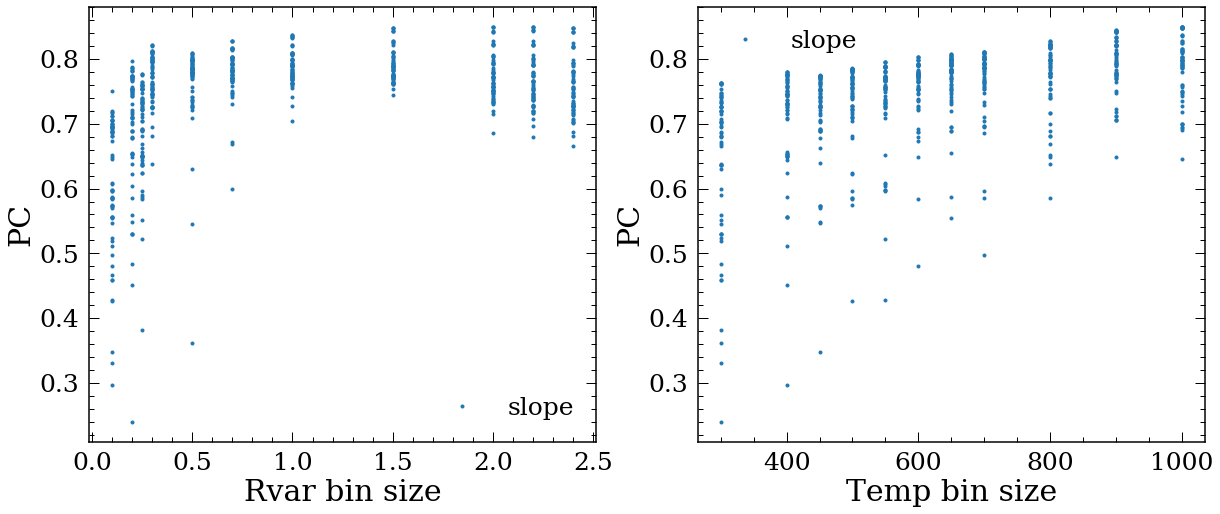

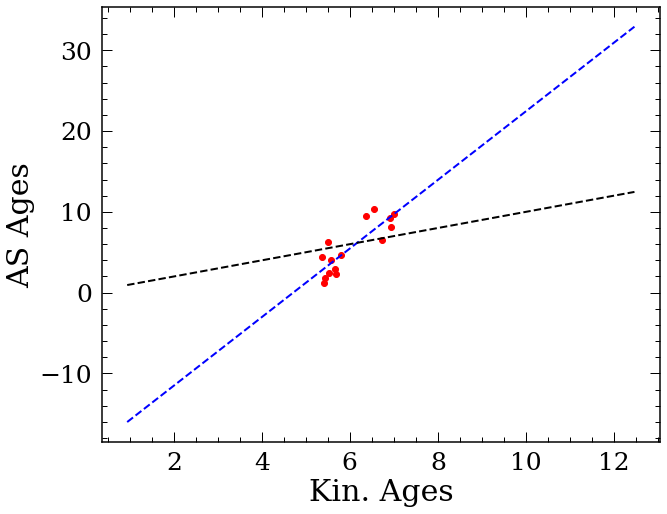

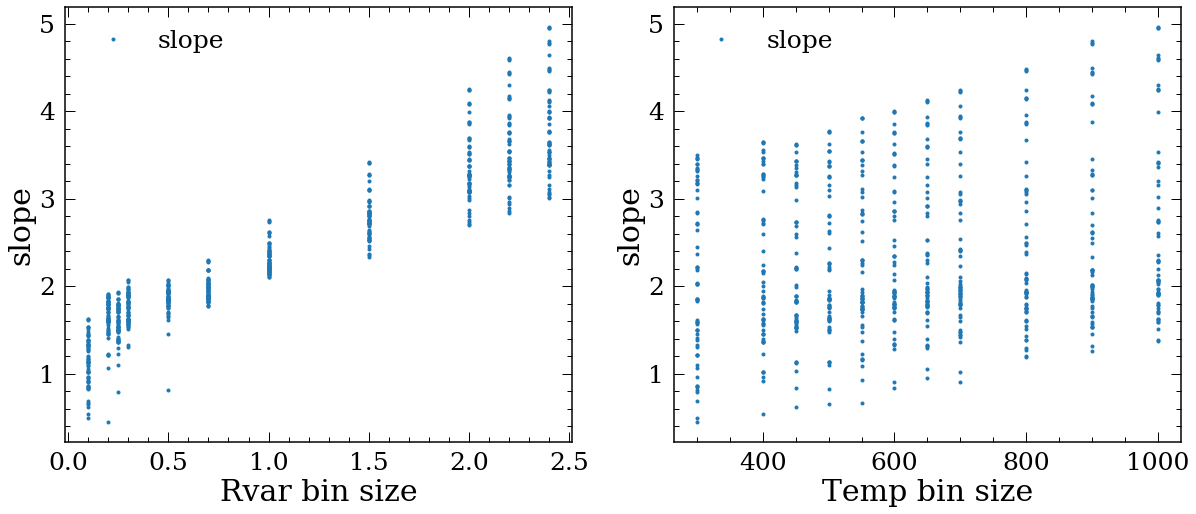

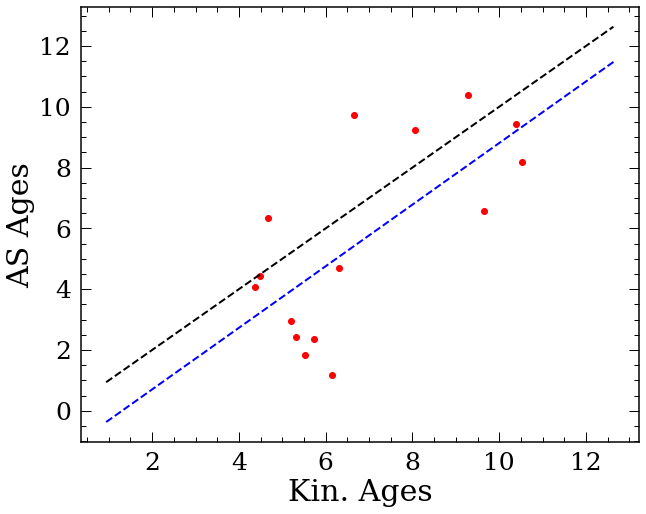

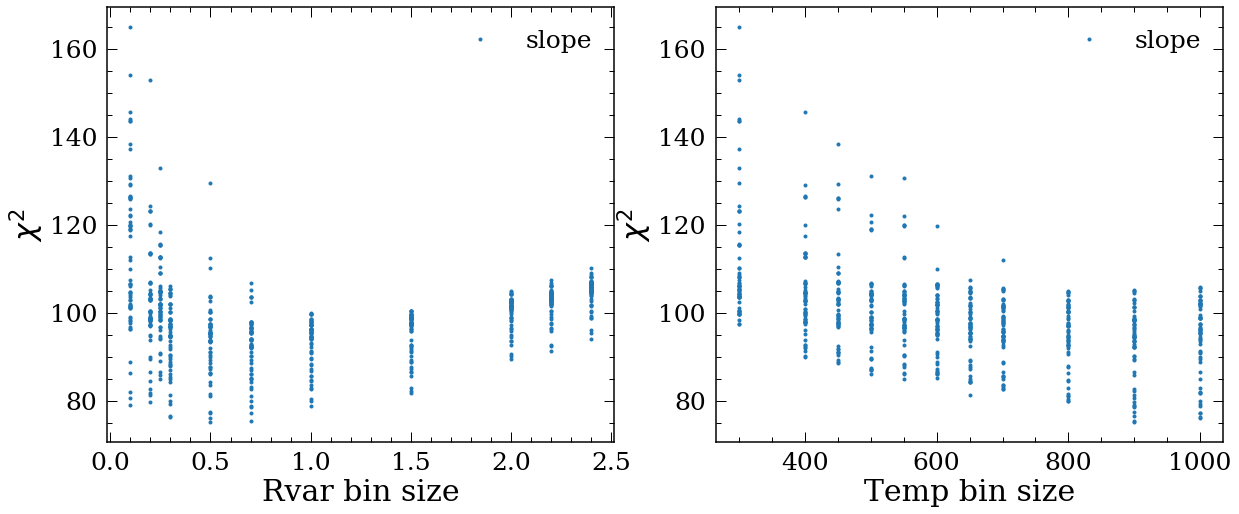

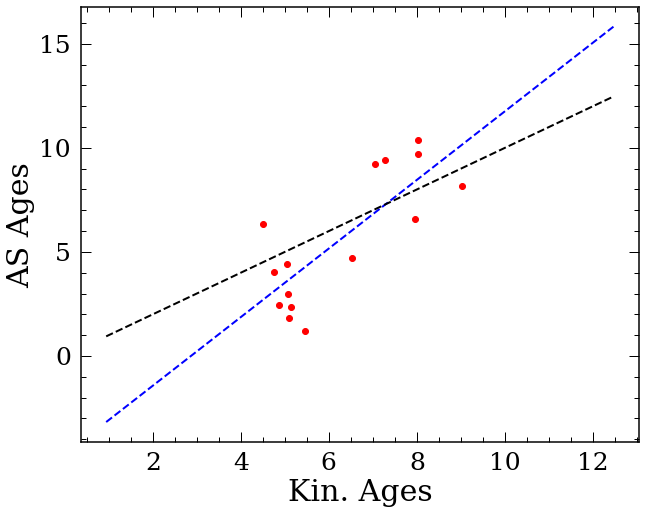

In [22]:
# Rvar
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(rotbin_a,pcs,'.',label='slope')
plt.xlabel('Rvar bin size')
plt.ylabel('PC')
#plt.ylim([-1,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(tempbin_a,pcs,'.',label='slope')
plt.xlabel('Temp bin size')
plt.ylabel('PC')
#plt.ylim([-1,1])
plt.legend()

pc_s,rotbin_a_s,tempbin_a_s,binloggs_s=zip(*sorted(zip([abs(i-1.) for i in pcs],rotbin_a,tempbin_a,binloggs_a)))
pc_s=[i+1. for i in pc_s]

print('max PC:',rotbin_a_s[0],tempbin_a_s[0],binloggs_s[0],pc_s[0])

slop_max,int_max,pc=Calcdv_bin(df,'teff_calc',f2,tempbin_a_s[0],rotbin_a_s[0],binloggs_s[0],df_cluster,plot=True)

print(slop_max,int_max,pc)




plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(rotbin_a,slopes,'.',label='slope')
plt.xlabel('Rvar bin size')
plt.ylabel('slope')
#plt.ylim([-1,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(tempbin_a,slopes,'.',label='slope')
plt.xlabel('Temp bin size')
plt.ylabel('slope')
#plt.ylim([-1,1])
plt.legend()

slopes_s,rotbin_a_s,tempbin_a_s,binloggs_s=zip(*sorted(zip([abs(i-1.) for i in slopes],rotbin_a,tempbin_a,binloggs_a)))
slopes_s=[i+1. for i in slopes_s]

print('max slope:',rotbin_a_s[0],tempbin_a_s[0],binloggs_s[0],slopes_s[0])

slop_max,int_max,pc=Calcdv_bin(df,'teff_calc',f2,tempbin_a_s[0],rotbin_a_s[0],binloggs_s[0],df_cluster,plot=True)

print(slop_max,int_max,pc)


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(rotbin_a,chisq,'.',label='slope')
plt.xlabel('Rvar bin size')
plt.ylabel('$\chi^2$')
#plt.ylim([-1,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(tempbin_a,chisq,'.',label='slope')
plt.xlabel('Temp bin size')
plt.ylabel('$\chi^2$')
#plt.ylim([-1,1])
plt.legend()

chisq_s,rotbin_a_s,tempbin_a_s,binloggs_s=zip(*sorted(zip(chisq,rotbin_a,tempbin_a,binloggs_a)))

print('min chi^2:',rotbin_a_s[0],tempbin_a_s[0],binloggs_s[0],chisq_s[0])

slop_max,int_max,pc=Calcdv_bin(df,'teff_calc',f2,tempbin_a_s[0],rotbin_a_s[0],binloggs_s[0],df_cluster,plot=True)

print(slop_max,int_max,pc)


max PC: 0.060000000000000005 500.0 0.6 1.0164143843466202
[ 1.46890529 -1.38987659]
1.4689052948514176 -1.3898765858958528 0.9835856156533798
max slope: 0.11 1000.0 0.6 1.0013757491430126


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[ 0.99862425 -0.28806288]
0.9986242508569874 -0.2880628772393503 0.5390013324430728
min chi^2: 0.06999999999999999 500.0 0.4 0.546438066759087


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[ 0.98618517 -0.16418694]
0.9861851726601403 -0.16418693701028544 0.8737987020601207


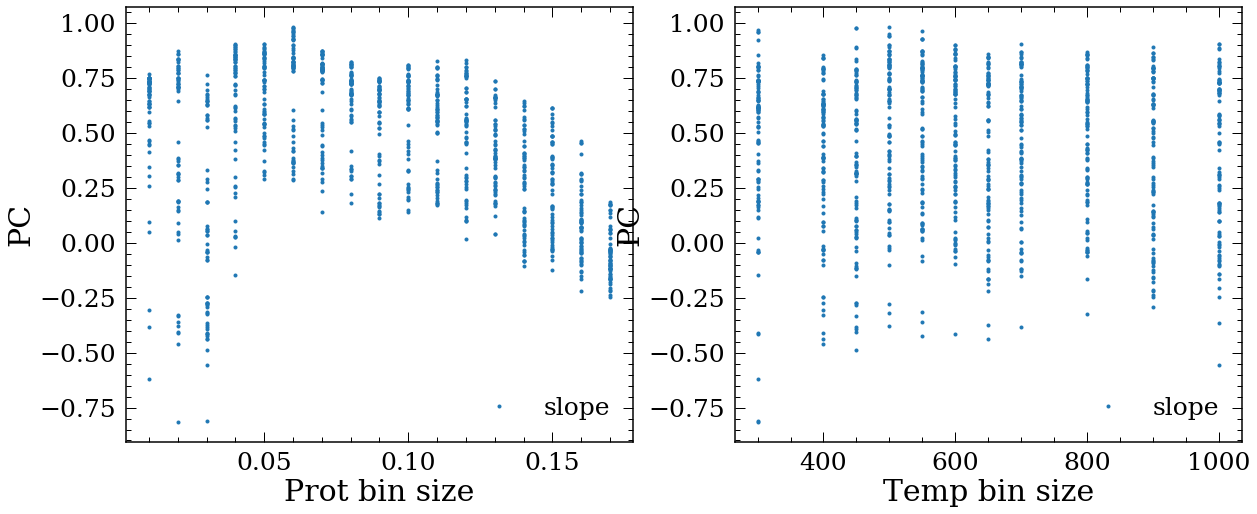

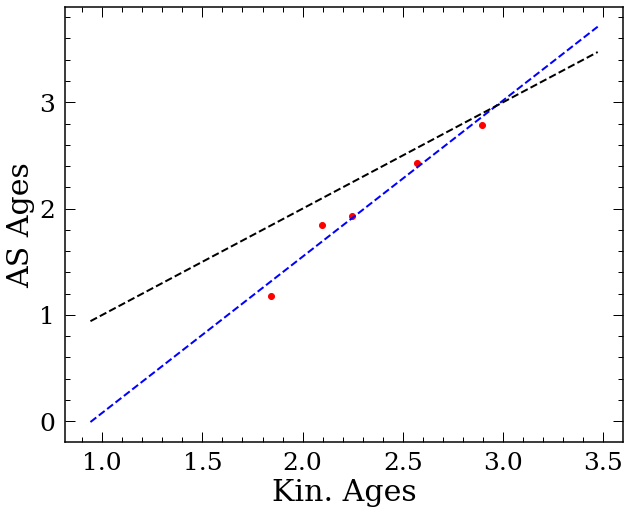

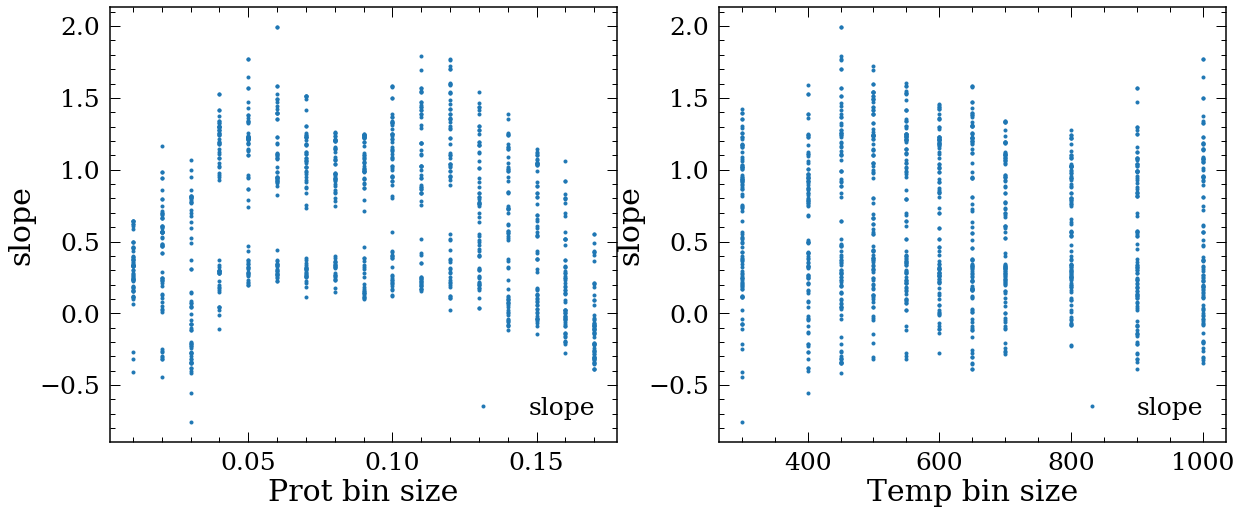

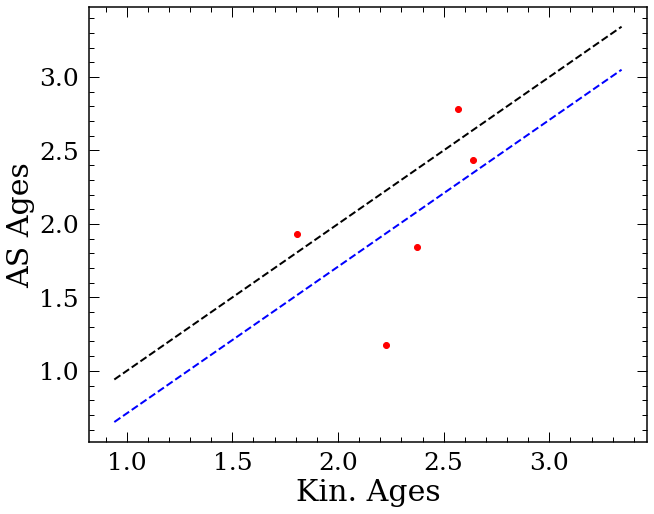

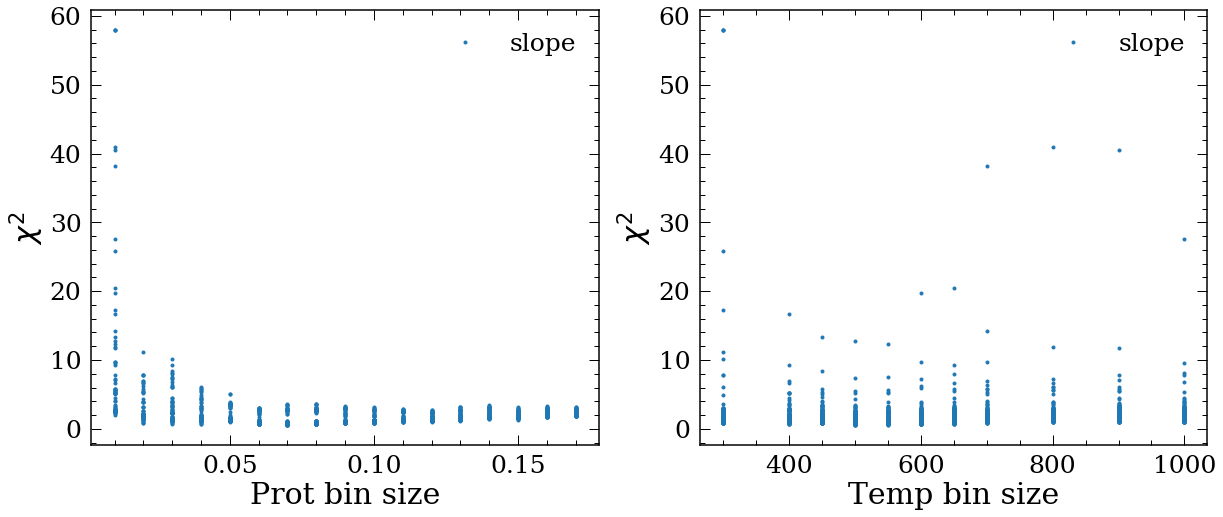

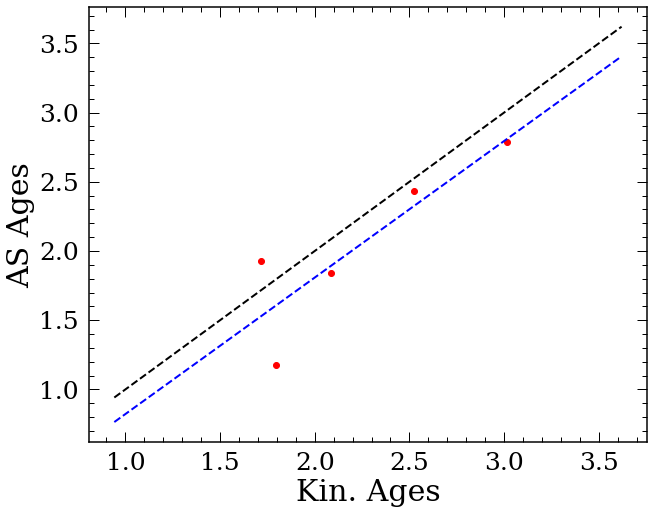

In [24]:
# Prot
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(rotbin_a,pcs,'.',label='slope')
plt.xlabel('Prot bin size')
plt.ylabel('PC')
#plt.ylim([-1,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(tempbin_a,pcs,'.',label='slope')
plt.xlabel('Temp bin size')
plt.ylabel('PC')
#plt.ylim([-1,1])
plt.legend()

pc_s,rotbin_a_s,tempbin_a_s,binloggs_s=zip(*sorted(zip([abs(i-1.) for i in pcs],rotbin_a,tempbin_a,binloggs_a)))
pc_s=[i+1. for i in pc_s]

print('max PC:',rotbin_a_s[0],tempbin_a_s[0],binloggs_s[0],pc_s[0])

slop_max,int_max,pc=Calcdv_bin(df,'teff_calc',f2,tempbin_a_s[0],rotbin_a_s[0],binloggs_s[0],df_cluster,plot=True)

print(slop_max,int_max,pc)




plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(rotbin_a,slopes,'.',label='slope')
plt.xlabel('Prot bin size')
plt.ylabel('slope')
#plt.ylim([-1,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(tempbin_a,slopes,'.',label='slope')
plt.xlabel('Temp bin size')
plt.ylabel('slope')
#plt.ylim([-1,1])
plt.legend()

slopes_s,rotbin_a_s,tempbin_a_s,binloggs_s=zip(*sorted(zip([abs(i-1.) for i in slopes],rotbin_a,tempbin_a,binloggs_a)))
slopes_s=[i+1. for i in slopes_s]

print('max slope:',rotbin_a_s[0],tempbin_a_s[0],binloggs_s[0],slopes_s[0])

slop_max,int_max,pc=Calcdv_bin(df,'teff_calc',f2,tempbin_a_s[0],rotbin_a_s[0],binloggs_s[0],df_cluster,plot=True)

print(slop_max,int_max,pc)


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(rotbin_a,chisq,'.',label='slope')
plt.xlabel('Prot bin size')
plt.ylabel('$\chi^2$')
#plt.ylim([-1,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(tempbin_a,chisq,'.',label='slope')
plt.xlabel('Temp bin size')
plt.ylabel('$\chi^2$')
#plt.ylim([-1,1])
plt.legend()

chisq_s,rotbin_a_s,tempbin_a_s,binloggs_s=zip(*sorted(zip(chisq,rotbin_a,tempbin_a,binloggs_a)))

print('min chi^2:',rotbin_a_s[0],tempbin_a_s[0],binloggs_s[0],chisq_s[0])

slop_max,int_max,pc=Calcdv_bin(df,'teff_calc',f2,tempbin_a_s[0],rotbin_a_s[0],binloggs_s[0],df_cluster,plot=True)

print(slop_max,int_max,pc)
